# Первые подходы для генерации текста через RNN

## Импорт библиотек

In [38]:
import os

import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Загрузка датасета

In [39]:
# Загрузка датасета
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('../dataset/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

## Предобработка

In [40]:
quotes[:3]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?']

In [41]:
# Малый препроцессинг
tokens = list(set(''.join(quotes)))
num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  85


In [42]:
# словарь токен - id
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [43]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [44]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [45]:

print('\n'.join(quotes[::2000]))
print(to_matrix(quotes[::2000], token_to_id))



 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 In the beginning, everybody that gets to work with me, thinks I'm nice. But three weeks later, they hear a bell ringing. Then they realise I meant everything I said during that first week. It's not my fault people are not taking me serious from the first moment.
 I tend to get comfortable with the dialogue and find out who the person is in the script and try to hit that. People are sort of independent of their occupations and their pastimes. You don't play a politician or a fireman or a cowboy - you just play a person.
 'Tis love that makes the world go round, my baby.
 Some of these kids just don't plain know how good they are: how smart and how much they have to say. You can tell them. You can shine that light on them, one human interaction at a time.
 I was able to realize that I definitely want to make sure that I use my voice, as it gets bigger and bigger, in the world 

In [46]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [47]:
# Объявление клетки Рекуррентные нейронные сети
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))


char_rnn = CharRNNCell()

In [48]:
# тренировка рекуррентной архитектуры
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [49]:
# Тренировка  сети - рекуррентки
from IPython.display import clear_outputfrom random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

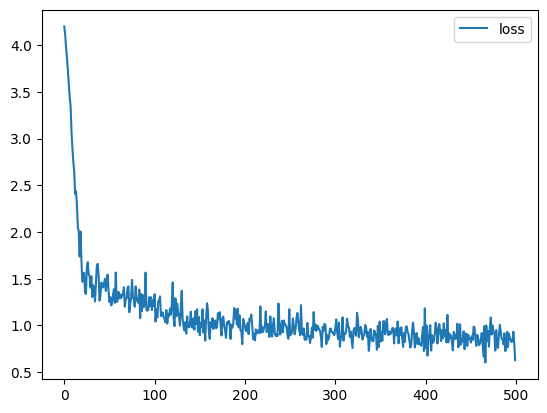

KeyboardInterrupt: 

In [50]:
MAX_LENGTH = max(map(len, quotes))

for i in range(1000):
    batch_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
# Генерация имен с помощью RNN
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])


In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn))

In [37]:
# Температура - как величина степени уверенности
for _ in range(3):
    print(generate_sample(char_rnn, temperature=0.4))

 I she the foun thas the the the the the the al the what wore at in the mere the the in the the the the the the pore ing the the the thing the the mean the bing and and in bet and and at the there the the the the the and and and the the ther and fe wher and the the the it andere for are the the hall and the tha mersthe merand the the the of an an to berens of to ar and an the meand and the the sore the the
 I ing in and in the the that the wo the whe pore of the the cat spacd the toure and an mere cothe and of the and on the of the and and wor the thas the sith wous and the and in the for in the the the the be to and and war beat  an in the and the be forit and the the the the what to we and of an sot do the bore and ant in the bere sing on the the foun and at and the an ant and to                           
 I the the pothe and and the bes and and in  a the an the were cothe in in the the the the and an and rom the the the de and polle in the for more bing of fing in the thithe the an